Data Preprocessing: Combine the data from Customers.csv and Transactions.csv to create a feature set that includes both customer profile information and transaction data.
Feature Engineering: Create meaningful features like total spend, average purchase frequency, product category preferences, etc.
Clustering: Use a clustering algorithm (e.g., K-Means) to segment customers into clusters based on the features we created.
Clustering Evaluation: Calculate clustering metrics such as the DB Index (Davies-Bouldin Index) to evaluate the quality of the clusters.
Visualization: Use 2D plots like PCA (Principal Component Analysis) or t-SNE to visualize the clusters.

1. Data Preprocessing
We need to combine both customer profile data (Customers.csv) and transaction data (Transactions.csv) to create a feature set.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('/content/drive/MyDrive/ZEOTAP /Customers.csv')
transactions = pd.read_csv('/content/drive/MyDrive/ZEOTAP /Transactions.csv')

# Display the first few rows of each dataset
print(customers.head())
print(transactions.head())


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


1.2 Merge Customer and Transaction Data
We will merge the Customers and Transactions datasets on CustomerID to have a complete profile for each customer that includes both demographic and transaction information

In [2]:
# Merge customer data with transaction data
customer_transactions = pd.merge(transactions, customers, on='CustomerID', how='left')

# Display the merged data
print(customer_transactions.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price     CustomerName         Region  SignupDate  
0      300.68  300.68   Andrea Jenkins         Europe  2022-12-03  
1      300.68  300.68  Brittany Harvey           Asia  2024-09-04  
2      300.68  300.68  Kathryn Stevens         Europe  2024-04-04  
3      601.36  300.68  Travis Campbell  South America  2024-04-11  
4      902.04  300.68    Timothy Perez         Europe  2022-03-15  


1.3 Feature Engineering
We will create several features based on transaction history and customer demographics:

Total Spend: Sum of TotalValue for each customer.
Average Transaction Value: Average of TotalValue for each customer.
Product Category Preferences: Frequency of each product category purchased by each customer.
Average Purchase Frequency: Number of transactions per customer.

In [9]:
# Total spend per customer
total_spend = customer_transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spend.rename(columns={'TotalValue': 'TotalSpend'}, inplace=True)

# Average transaction value per customer
avg_transaction_value = customer_transactions.groupby('CustomerID')['TotalValue'].mean().reset_index()
avg_transaction_value.rename(columns={'TotalValue': 'AvgTransactionValue'}, inplace=True)

# Number of transactions per customer (purchase frequency)
purchase_frequency = customer_transactions.groupby('CustomerID').size().reset_index(name='PurchaseFrequency')


# Combine all the features into a single dataframe
customer_features = pd.merge(total_spend, avg_transaction_value, on='CustomerID')
customer_features = pd.merge(customer_features, purchase_frequency, on='CustomerID')

# Display the features for customers
print(customer_features.head())


  CustomerID  TotalSpend  AvgTransactionValue  PurchaseFrequency
0      C0001     3354.52              670.904                  5
1      C0002     1862.74              465.685                  4
2      C0003     2725.38              681.345                  4
3      C0004     5354.88              669.360                  8
4      C0005     2034.24              678.080                  3


2.Clustering with K-Means
We will use K-Means clustering to segment customers into a defined number of clusters. We will also evaluate the quality of clustering using the Davies-Bouldin Index (DBI).

2.1 Standardizing the Features
We will standardize the data so that no single feature dominates the clustering algorithm.

In [10]:
# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop('CustomerID', axis=1))

# Display the first few rows of scaled features
print(scaled_features[:5])


[[-0.06170143 -0.07026341 -0.01145819]
 [-0.87774353 -0.93493297 -0.46749414]
 [-0.40585722 -0.02627131 -0.46749414]
 [ 1.03254704 -0.0767689   1.35664965]
 [-0.78392861 -0.04002806 -0.92353008]]


2.2 Choosing the Optimal Number of Clusters
We can use the Elbow Method to determine the optimal number of clusters. The "elbow" point is where the inertia (sum of squared distances from the centroids) starts to decrease more slowly.

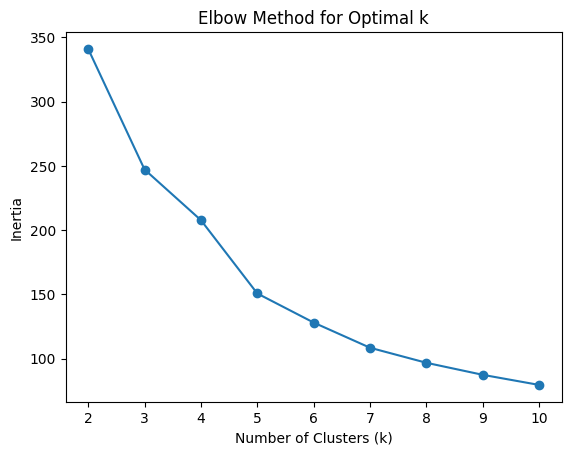

In [11]:
# Calculate inertia for different values of k (clusters)
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


From the elbow plot, choose the number of clusters (let's assume we choose k=4 as an example).

2.3 K-Means Clustering
Now that we have chosen the optimal number of clusters, let's apply the K-Means algorithm.

In [12]:
# Perform K-Means clustering with k=4
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)

# Display the cluster assignments for the first few customers
print(customer_features[['CustomerID', 'Cluster']].head())


  CustomerID  Cluster
0      C0001        3
1      C0002        1
2      C0003        3
3      C0004        0
4      C0005        3


3. Clustering Evaluation: Davies-Bouldin Index (DBI)
The Davies-Bouldin Index (DBI) is a metric to evaluate the quality of clustering. A lower DBI indicates better clustering.

In [13]:
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 1.060424039992303


4.Visualization
We will use PCA (Principal Component Analysis) to reduce the dimensions of the feature space to 2D so we can visualize the clusters.

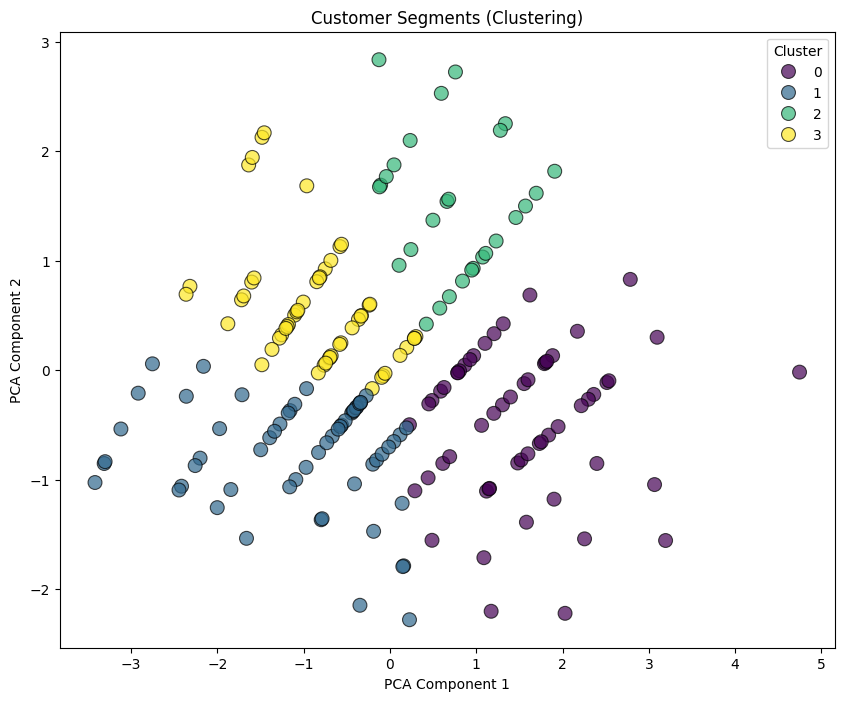

In [14]:
# Perform PCA to reduce the dimensions to 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Add PCA components to the customer data
customer_features['PCA1'] = pca_components[:, 0]
customer_features['PCA2'] = pca_components[:, 1]

# Plot the clusters using the PCA components
plt.figure(figsize=(10, 8))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100, alpha=0.7, edgecolor='black')
plt.title('Customer Segments (Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


5. Save the Results
Finally, we can save the results (cluster assignments) to a CSV file.


In [15]:
# Save the customer IDs and their corresponding cluster assignments to a CSV
customer_features[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)

# Display the saved file
print(customer_features[['CustomerID', 'Cluster']].head())


  CustomerID  Cluster
0      C0001        3
1      C0002        1
2      C0003        3
3      C0004        0
4      C0005        3
